# Uganda Power Grid Optimization

This notebook is a pre-processing script that will read in shapefiles and convert to the input to a powergrid optimization model. We are testing this within Uganda. The inputs to this model:

- A shapefile of existing power grid lines. These lines have an 'id' attribute, a 'capacity' attribute, and a 'loss_factr' attribute.
- A shapefile of lines representing potential new construction of existing line upgrades. These lines have the following attributes:
    - 'id'
    - 'ad_cap_a': The potential additional capacity for option A
    - 'ad_cap_b': The potential additional capacity for option B
    - 'con_cost_a': The potential construction cost for option A
    - 'con_cost_b': The potential construction cost for option B
- A shapefile of existing and potential power grid nodes. These nodes have an 'id' attribute, and a 'demand' attribute.

The outputs to this models are CSVs, that will be used for OR analysis inputs.

## import libraries

In [557]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [558]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [559]:
# Define input data and create a number of output datasets if they do not yet exist
inputFolder = r'./input_folder'

input_power_lines_gpd = gpd.read_file(os.path.join(inputFolder, "power_lines.shp"))
input_new_connection_options_gpd = gpd.read_file(os.path.join(inputFolder, "new_connection_options.shp"))
 
input_power_nodes_gpd = gpd.read_file(os.path.join(inputFolder, "power_nodes.shp"))

In [560]:
outputFolder = r'./output_folder'

In [561]:
pd.set_option('precision', 4)

## Documentation (possible to skip ahead)

We have used the following routine before as found below to import shapefiles into a graph. This routine deconstructs all of the edges and puts them back together, creating the nodes based on the input node dataset. Also with this routine, the intersections must explicitly have nodes on them.

The problem with using this routing for this analysis is that when the lines are being unioned extra lines are being created whenever the unioned line self-intersects.

In [562]:
# deconstructing the power line network into a geodataframe of points
bag_of_points,ids = [],[]
id_ = 0
for r in input_power_lines_gpd.geometry:
    for q in r.coords:
        bag_of_points.append(q)
        ids.append(id_)
        id_+=1

df_temp = pd.DataFrame(({'ids':ids,'geometry':bag_of_points}))
df_temp['geometry'] = df_temp['geometry'].apply(Point)
gdf_temp = gpd.GeoDataFrame(df_temp, crs = input_power_lines_gpd.crs, geometry = 'geometry')

In [563]:
# the source_crs should be the same proj as both the input graph and input geodataframe of points
# the nodes need to be snapped to the lines because later the snapped points will be used to split the lines
input_power_nodes_snapped = gn.pandana_snap_points(input_power_nodes_gpd, 
                                          gdf_temp, 
                                          source_crs = 'epsg:4326', 
                                          target_crs = 'epsg:4326',
                                          add_dist_to_node_col = True)

input_power_nodes_snapped_temp = input_power_nodes_snapped.drop_duplicates('NN')

In [564]:
# When the nodes got snapped to the nearest node in the dataframe the original geometry is being retained
# but it is adding the NN id and the NN_distance

# Therefore join to the node gdf to add the geometries of the nodes snapped to
input_power_nodes_snapped_temp = input_power_nodes_snapped_temp.rename(columns={"geometry": "original_geometry"})
input_power_nodes_snapped_temp_joined = input_power_nodes_snapped_temp.set_index('NN').join(gdf_temp.set_index('ids'))
input_power_nodes_snapped_temp_joined = input_power_nodes_snapped_temp_joined.reset_index()

In [565]:
# note, when both the original_geometry and geometry columns exist there was an error in outputting a shapefile
# it must have been confused with two geometry columns, therefore the 'original_geometry' column should be dropped
input_power_nodes_snapped_temp_joined_slim = input_power_nodes_snapped_temp_joined.drop(columns="original_geometry")

In [566]:
input_power_nodes_snapped_temp_joined_geo = gpd.GeoDataFrame(input_power_nodes_snapped_temp_joined_slim, crs = input_power_lines_gpd.crs, geometry = 'geometry')
# preview the snapped nodes
# input_power_nodes_snapped_temp_joined_geo.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/snapped_power_nodes.shp')

In [567]:
# number of lines from the imported shapefile
len(input_power_lines_gpd)

8

In [568]:
allPowerLines = unary_union(input_power_lines_gpd['geometry'])

bag_of_relevant_points = unary_union(input_power_nodes_snapped_temp_joined_geo.geometry)

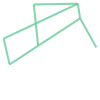

In [569]:
allPowerLines

In [570]:
# number of lines after the union is 10 because the unioned line intersects itself
len(allPowerLines)

10

In [571]:
# a shapely.ops function
split_geoms = split(allPowerLines, bag_of_relevant_points)

#print('print count of split geometries')
#print(len(split_geoms))

geom_bag = []

for geom in split_geoms:
    g = geom.coords[0]
    h = geom.coords[-1]
    geom_bag.append(str(g))
    geom_bag.append(str(h))

In [572]:
ref = pd.DataFrame({'node_ids':range(0, len(geom_bag)),'geoms':geom_bag})
ref = ref.drop_duplicates('geoms')
ref = ref.set_index('geoms')

nodes = []
edges = []

for geom in split_geoms:
    u_data,v_data,edge_data = {},{},{}

    # start node
    # it is getting a reference to that node's coords
    u = ref['node_ids'].loc[str(geom.coords[0])]
    u_data['x'] = geom.coords[0][0]
    u_data['y'] = geom.coords[0][1]
    u_data['geom'] = Point(geom.coords[0])
    #u_data['string'] = str(geom.coords[0])

    # end node
    v = ref['node_ids'].loc[str(geom.coords[-1])]
    v_data['x'] = geom.coords[-1][0]
    v_data['y'] = geom.coords[-1][1]
    v_data['geom'] = Point(geom.coords[-1])
    #v_data['string'] = str(geom.coords[-1])

    # edge
    edge_data['geom'] = geom
    edge_data['length'] = geom.length
    #edge_data['rail_type'] = geom.rail_type

    nodes.append((u,u_data))
    nodes.append((v,v_data))
    edges.append((u,v,edge_data))
    edges.append((v,u,edge_data))

    id_ += 2

G_PowerLines = nx.MultiDiGraph()
G_PowerLines.add_nodes_from(nodes)
G_PowerLines.add_edges_from(edges)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

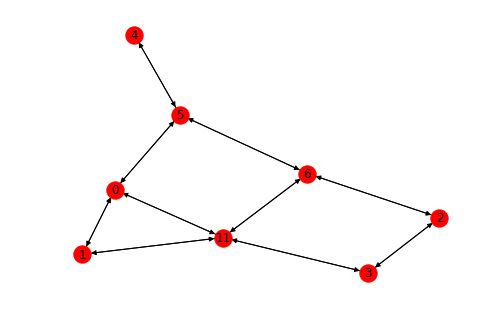

In [573]:
nx.draw(G_PowerLines, with_labels = True)

### Find all edges that intersect the input lines and where they do add the attributes to the edges

In [574]:
# Remember that this is a MultiDiGraph so there are two directed edges between each pair of nodes. 
graph_edge_count = 0
graph_edge_intersects = 0
graph_edge_no_intersects = 0

# loop through each edge in the graph
for edge in G_PowerLines.edges(data=True):
    graph_edge_count += 1
    # loop through each power line in the input railway geodataframe
    for row in input_power_lines_gpd.itertuples(index=False):
        # if there is an intersection
        if edge[2]['geom'].intersects(row.geometry):
            # print("an intersection has occurred")
            graph_edge_intersects += 1
            # for the edge add all the attributes that are not length or geometry
            row_dict = row._asdict()
            for name,value in row_dict.items():
                if not (name=='geometry' or name=='length'):
                    #print(name)
                    # This updates the edge and adds a new attribute key and value
                    #G_rail[edge[0]][edge[1]][0].update(name=value)
                    G_PowerLines[edge[0]][edge[1]][0][name]=value
        else:
            graph_edge_no_intersects += 1

#nx.write_gpickle(G_PowerLines, outPowerLinesGraph)

print(graph_edge_count)
print(graph_edge_intersects)
print(graph_edge_no_intersects)

20
72
88


### Find all nodes that intersect the input nodes and where they do add the attributes to the nodes

In [575]:
for node in G_PowerLines.nodes(data=True):
    #print(node)
    # loop through each power node in the input power node geodataframe
    for row in input_power_nodes_snapped_temp_joined_geo.itertuples(index=False):
        # if there is an intersection
        if node[1]['geom'].intersects(row.geometry):
            # print('match')
            # for the node add all the attributes that are not geometry
            row_dict = row._asdict()
            for name,value in row_dict.items():
                if not (name == 'geometry'):
                    #print(name)
                    #print(G_PowerLines.node[node])
                    # This updates the node and adds a new attribute key and value
                    #G_rail[edge[0]][edge[1]][0].update(name=value)
                    #G_PowerLines[node[1]][name] = value
                    G_PowerLines.nodes[node[0]][name] = value

## visualize network

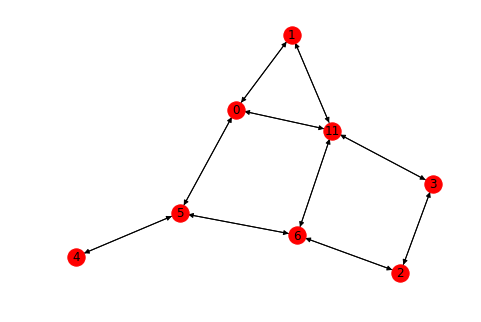

In [576]:
nx.draw(G_PowerLines, with_labels = True)

## (Back to analysis) Importing Shapefiles

In [577]:
# let's try something different where we will read the shapefiles from NetworkX
# Both the lines and the nodes are within the directory
G1 = nx.read_shp(os.path.join(inputFolder, "import_shp_files/"))

In [578]:
G1

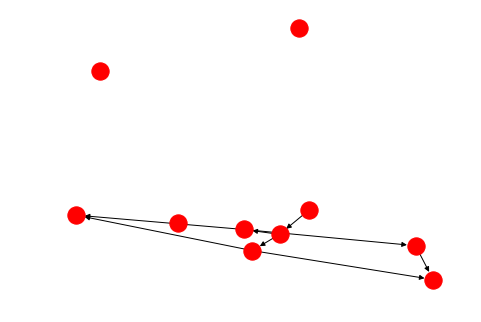

In [579]:
nx.draw(G1)

In [580]:
type(G1)

networkx.classes.digraph.DiGraph

In [581]:
G1_graph = G1.to_undirected()

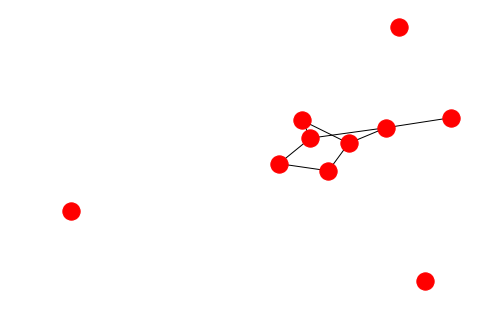

In [582]:
nx.draw(G1_graph)

In [583]:
type(G1_graph)

networkx.classes.graph.Graph

In [584]:
id_set = input_power_nodes_gpd.id

In [585]:
power_node_ids = sorted(list(id_set))

In [586]:
# create a zeroed out matrix that has the node ids are columns and row labels
matrix = pd.DataFrame(0, index=power_node_ids, columns=power_node_ids)

In [587]:
#matrix

In [588]:
capacity_matrix = matrix.copy()
loss_factr_matrix = matrix.copy()

### The loss_factr_matrix needs to be a float type because the loss factors are in decimals

In [589]:
loss_factr_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 10 columns):
1     10 non-null int64
2     10 non-null int64
3     10 non-null int64
4     10 non-null int64
5     10 non-null int64
6     10 non-null int64
7     10 non-null int64
8     10 non-null int64
9     10 non-null int64
10    10 non-null int64
dtypes: int64(10)
memory usage: 880.0 bytes


In [590]:
# we need to change the dtypes form ints to floats
loss_factr_matrix = loss_factr_matrix.astype('float')

In [591]:
# test:
#loss_factr_matrix.at[1, 2] = .05
#loss_factr_matrix

In [592]:
type(loss_factr_matrix)

pandas.core.frame.DataFrame

In [593]:
#G1_graph.get_edge_data((33.362550629919305, 3.2972712424907833),(33.33385735159716, 3.348764698405603))

In [594]:
#G1_graph.get_edge_data((33.362550629919305, 3.2972712424907833),(33.33385735159716, 3.348764698405603))['capacity']

## The code below parses each node in the graph, finds their neighbors and populates the capacity matrix

In [595]:
for n in G1_graph.nodes(data = True):
    # from node
    print('node id:')
    print(n[0])
    from_node = n[0]
    print('origin_node:')
    print(to_node)
    #print(G1_graph.nodes[n[0]]['id'])
    from_node_id = G1_graph.nodes[n[0]]['id']
    #print(list(G1_graph.neighbors(n[0])))
    # print entries in the list
    print('node neighbors:')
    for entry in list(G1_graph.neighbors(n[0])):
        #print(entry)
        to_node = entry
        print('to_node:')
        print(to_node)
        #print(G1_graph.nodes[entry]['id'])
        to_node_id = G1_graph.nodes[entry]['id']
        print('print edge')
        print(G1_graph.get_edge_data(from_node, to_node)['capacity'])
        capacity = G1_graph.get_edge_data(from_node, to_node)['capacity']
        loss_factr = G1_graph.get_edge_data(from_node, to_node)['loss_factr']
        print(loss_factr)
        capacity_matrix.at[from_node_id, to_node_id] = capacity
        loss_factr_matrix.at[from_node_id, to_node_id] = loss_factr

node id:
(33.362550629919305, 3.2972712424907833)
origin_node:
10
node neighbors:
to_node:
(33.33385735159716, 3.348764698405603)
print edge
1000
0.03
node id:
(33.33385735159716, 3.348764698405603)
origin_node:
(33.33385735159716, 3.348764698405603)
node neighbors:
to_node:
(33.362550629919305, 3.2972712424907833)
print edge
1000
0.03
to_node:
(33.32978257461352, 3.3747954446455584)
print edge
500
0.05
to_node:
(33.259312033268635, 3.300273927870942)
print edge
500
0.05
node id:
(33.32978257461352, 3.3747954446455584)
origin_node:
(33.259312033268635, 3.300273927870942)
node neighbors:
to_node:
(33.33385735159716, 3.348764698405603)
print edge
500
0.05
to_node:
(33.19826147592042, 3.312955821872942)
print edge
200
0.07
to_node:
(33.25167789484355, 3.3734511466084047)
print edge
200
0.07
node id:
(33.259312033268635, 3.300273927870942)
origin_node:
(33.25167789484355, 3.3734511466084047)
node neighbors:
to_node:
(33.33385735159716, 3.348764698405603)
print edge
500
0.05
to_node:
(33.25

In [596]:
capacity_matrix

,1,2,3,4,5,6,7,8,9,10
1,0,1000,0,0,0,0,0,0,0,0
2,1000,0,500,500,0,0,0,0,0,0
3,0,500,0,0,500,500,0,0,0,0
4,0,500,0,0,0,200,200,0,0,0
5,0,0,500,0,0,0,200,0,0,0
6,0,0,500,200,0,0,0,0,0,0
7,0,0,0,200,200,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0


In [607]:
capacity_matrix.to_csv(os.path.join(outputFolder, "capacity_matrix.csv"))

In [597]:
loss_factr_matrix

,1,2,3,4,5,6,7,8,9,10
1,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
2,0.03,0.00,0.05,0.05,0.00,0.00,0.00,0.0,0.0,0.0
3,0.00,0.05,0.00,0.00,0.05,0.05,0.00,0.0,0.0,0.0
4,0.00,0.05,0.00,0.00,0.00,0.07,0.07,0.0,0.0,0.0
5,0.00,0.00,0.05,0.00,0.00,0.00,0.08,0.0,0.0,0.0
6,0.00,0.00,0.05,0.07,0.00,0.00,0.00,0.0,0.0,0.0
7,0.00,0.00,0.00,0.07,0.08,0.00,0.00,0.0,0.0,0.0
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0


In [608]:
loss_factr_matrix.to_csv(os.path.join(outputFolder, "loss_factr_matrix.csv"))

## Generate 2nd set of CSVs from the new connection options graph
### There is another shapefile that represents possible new connection lines and line upgrades to existing lines.
#### These lines have columns that represent up to two different new capacity upgrades and two columns that represent the associated costs

In [598]:
G_new_conn = nx.read_shp(os.path.join(inputFolder, "import_shp_files_new_connections/"))

In [599]:
G_new_conn

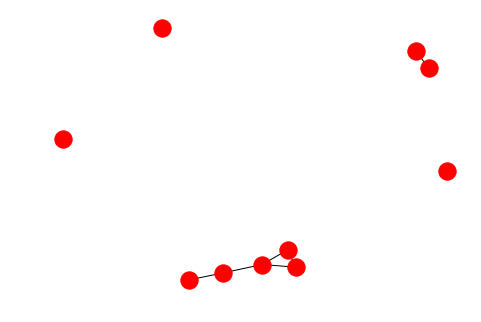

In [600]:
G_new_conn = G_new_conn.to_undirected()
nx.draw(G_new_conn)

In [601]:
# create new pandas dataframes for the outputs
df_new_conn_capacity = pd.DataFrame(columns=['label', 'value'])
df_new_conn_cost = pd.DataFrame(columns=['label', 'value'])

## The code below parses each edge in the graph, finds the to and from nodes, and populates the appropriate pandas dataframe with the connection capacity and costs

In [602]:
# Import lines
# For each edge
for e in G_new_conn.edges(data = True):
    # For each edge's attribute
    print(e)
    #print(e[1])
    # print edge from node
    #print(G_new_conn.nodes[e[0]]['id'])
    from_node = G_new_conn.nodes[e[0]]['id']
    # print edge to node
    #print(G_new_conn.nodes[e[1]]['id'])
    to_node = G_new_conn.nodes[e[1]]['id']
    # print additional network capacity
    print(e[2]['ad_cap_a'])
    ad_cap_a = e[2]['ad_cap_a']
    
    label = str(from_node) + '.' + str(to_node) + '.A'
    print(label)
    
    df2 = pd.DataFrame([[label, ad_cap_a]], columns=['label', 'value'])
    #print('print df2')
    #print(df2)
    df_new_conn_capacity = df_new_conn_capacity.append(df2)
    #G_new_conn.edges
    # print new connection cost
    print(e[2]['ad_cap_b'])
    label = str(from_node) + '.' + str(to_node) + '.B'
    ad_cap_b = e[2]['ad_cap_b']
    
    df2 = pd.DataFrame([[label, ad_cap_b]], columns=['label', 'value'])
    df_new_conn_capacity = df_new_conn_capacity.append(df2)
    
    print(e[2]['con_cost_a'])
    
    label = str(from_node) + '.' + str(to_node) + '.A'
    con_cost_a = e[2]['con_cost_a']
    
    df2 = pd.DataFrame([[label, con_cost_a]], columns=['label', 'value'])
    df_new_conn_cost = df_new_conn_cost.append(df2)
    
    print(e[2]['con_cost_b'])
    
    label = str(from_node) + '.' + str(to_node) + '.B'
    con_cost_b = e[2]['con_cost_b']
    
    df2 = pd.DataFrame([[label, con_cost_b]], columns=['label', 'value'])
    df_new_conn_cost = df_new_conn_cost.append(df2)

((33.33385735159716, 3.348764698405603), (33.32978257461352, 3.3747954446455584), {'id': 7, 'ad_cap_a': 1000, 'ad_cap_b': 500, 'con_cost_a': 20, 'con_cost_b': 10, 'ShpName': 'new_connection_options', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x02@@\xaa\xbb\xd6sQ\xca@\n\xcaE%m6\x01@@\xaa6P\xbe`\xbc@\n\xff\x94\xc1\x0b\x8a$', 'Wkt': 'LINESTRING (33.3338573515972 3.3487646984056,33.3297825746135 3.37479544464556)', 'Json': '{ "type": "LineString", "coordinates": [ [ 33.33385735159716, 3.348764698405603 ], [ 33.329782574613517, 3.374795444645558 ] ] }'})
1000
2.4.A
500
20
10
((33.19826147592042, 3.312955821872942), (33.278610543040095, 3.2484234015116127), {'id': 6, 'ad_cap_a': 0, 'ad_cap_b': 200, 'con_cost_a': 0, 'con_cost_b': 31, 'ShpName': 'new_connection_options', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x02@@\x99`\xa1\xcd\x91D@\n\x80\xee\xfb`K\xf4@@\xa3\xa9\x82\xa1V\xc9@\t\xfc\xc5h\x88my', 'Wkt': 'LINESTRING (33.1982614759204 3.31295582187294,33.2786105430401 3.24842340151161)', 'Json'

In [603]:
df_new_conn_capacity

,label,value
0,2.4.A,1000
0,2.4.B,500
0,7.10.A,0
0,7.10.B,200
0,7.9.A,300
0,7.9.B,0
0,6.8.A,300
0,6.8.B,200
0,8.10.A,300
0,8.10.B,200


In [612]:
df_new_conn_capacity.to_csv(os.path.join(outputFolder, "new_conn_capacity.csv"), index=False)

In [610]:
df_new_conn_cost

,label,value
0,2.4.A,20
0,2.4.B,10
0,7.10.A,0
0,7.10.B,31
0,7.9.A,30
0,7.9.B,0
0,6.8.A,25
0,6.8.B,30
0,8.10.A,28
0,8.10.B,32


In [613]:
df_new_conn_cost.to_csv(os.path.join(outputFolder, "new_conn_cost.csv"), index=False)